# Classifier using LSTM layers

## 1. Importing Libraries

In [16]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [17]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/sketchrnn/sketchrnn_calculator.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [18]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes

    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)

    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]

    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0

    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]

    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_calculator_drawings = resize_and_normalize_drawings(calculator_data, size=MAX_SEQ_LENGTH)
resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

# TODO: Limitar dataset
resized_calculator_drawings = resized_calculator_drawings[:5120]
resized_cellphone_drawings = resized_cellphone_drawings[:5120]
resized_camera_drawings = resized_camera_drawings[:5120]

resized_camera_drawings.shape, resized_cellphone_drawings.shape, resized_calculator_drawings.shape

((5120, 95, 3), (5120, 95, 3), (5120, 95, 3))

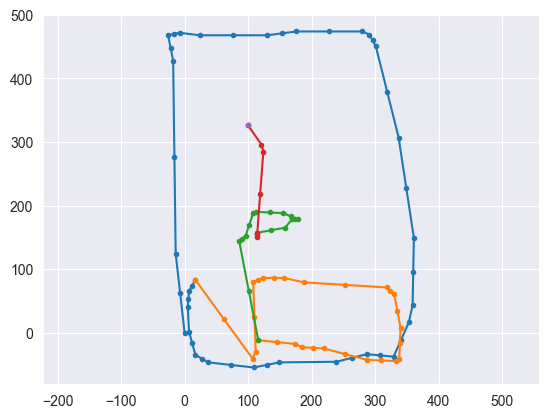

In [19]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()

    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()

draw_strokes(resized_calculator_drawings[0])

In [20]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, calculator_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras, cellphones, and calculators.

    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    calculator_drawings (np.array): Resized drawings of calculators.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    camera_labels = np.ones(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0]) * 2
    calculator_labels = np.zeros(calculator_drawings.shape[0])

    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings, calculator_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels, calculator_labels], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, resized_calculator_drawings, test_size=0.2)

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12288, 95, 3), (12288,), (3072, 95, 3), (3072,))

In [22]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
print(len(train_loader))
print(len(test_loader))

192
48


## 3. Model Building

### 3.1. Quantum Layer

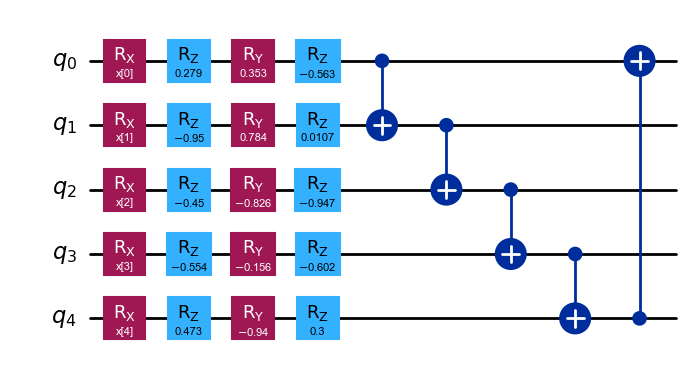

In [24]:
import random
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def generate_random_params(num_params, lower_bound=-1, upper_bound=1, seed=None):
    if seed is not None:
        random.seed(seed)
    return [random.uniform(lower_bound, upper_bound) for _ in range(num_params)]

def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    # Generar valores aleatorios para los parámetros del ansatz con una semilla
    fixed_params = generate_random_params(3 * n, seed=42)
    parameter_values = {param: value for param, value in zip(ansatz.parameters, fixed_params)}
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz.assign_parameters(parameter_values), inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN (
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=None,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)

        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [26]:
checkpoint_filepath = 'models/2edition_quantum_lstm_qfixed/best_model_weights_3classes.pth'

In [27]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)
        
    # Imprimir parámetros entrenables
    #print("Entrenando parámetros en la época", epoch + 1)
    #for name, param in model.named_parameters():
    #    if param.requires_grad:
    #        print(f"{name}: {param.data}")

100%|██████████| 192/192 [03:46<00:00,  1.18s/it]


Epoch 1, Accuracy: 0.4217936197916667, Loss: 1.0964434382816155, Validation Accuracy: 0.5677083333333334, Validation Loss: 1.093253493309021


100%|██████████| 192/192 [03:53<00:00,  1.21s/it]


Epoch 2, Accuracy: 0.6241048177083334, Loss: 1.0881847497075796, Validation Accuracy: 0.5439453125, Validation Loss: 1.08800208568573


100%|██████████| 192/192 [04:08<00:00,  1.30s/it]


Epoch 3, Accuracy: 0.5679524739583334, Loss: 1.0811767615377903, Validation Accuracy: 0.6416015625, Validation Loss: 1.0768924951553345


100%|██████████| 192/192 [04:07<00:00,  1.29s/it]


Epoch 4, Accuracy: 0.6454264322916666, Loss: 1.0734344199299812, Validation Accuracy: 0.6497395833333334, Validation Loss: 1.0694137811660767


100%|██████████| 192/192 [04:03<00:00,  1.27s/it]


Epoch 5, Accuracy: 0.645263671875, Loss: 1.066974263638258, Validation Accuracy: 0.6305338541666666, Validation Loss: 1.065258502960205


100%|██████████| 192/192 [04:02<00:00,  1.26s/it]


Epoch 6, Accuracy: 0.6473795572916666, Loss: 1.0602558963000774, Validation Accuracy: 0.6448567708333334, Validation Loss: 1.0570474863052368


100%|██████████| 192/192 [04:10<00:00,  1.30s/it]


Epoch 7, Accuracy: 0.6424967447916666, Loss: 1.054815910756588, Validation Accuracy: 0.6458333333333334, Validation Loss: 1.0508662462234497


100%|██████████| 192/192 [04:21<00:00,  1.36s/it]


Epoch 8, Accuracy: 0.64892578125, Loss: 1.0478325554480155, Validation Accuracy: 0.6350911458333334, Validation Loss: 1.046862244606018


100%|██████████| 192/192 [04:19<00:00,  1.35s/it]


Epoch 9, Accuracy: 0.6446126302083334, Loss: 1.0428090213487546, Validation Accuracy: 0.6409505208333334, Validation Loss: 1.040490746498108


100%|██████████| 192/192 [04:15<00:00,  1.33s/it]


Epoch 10, Accuracy: 0.6322428385416666, Loss: 1.0151300942525268, Validation Accuracy: 0.6272786458333334, Validation Loss: 0.9584543704986572


100%|██████████| 192/192 [04:07<00:00,  1.29s/it]


Epoch 11, Accuracy: 0.6405436197916666, Loss: 0.9086547770226995, Validation Accuracy: 0.6442057291666666, Validation Loss: 0.879973828792572


100%|██████████| 192/192 [04:12<00:00,  1.32s/it]


Epoch 12, Accuracy: 0.6319986979166666, Loss: 0.8730430422971646, Validation Accuracy: 0.6402994791666666, Validation Loss: 0.839285671710968


100%|██████████| 192/192 [04:12<00:00,  1.31s/it]


Epoch 13, Accuracy: 0.6336263020833334, Loss: 0.8450283998002609, Validation Accuracy: 0.6165364583333334, Validation Loss: 0.859335720539093


100%|██████████| 192/192 [04:15<00:00,  1.33s/it]


Epoch 14, Accuracy: 0.6288248697916666, Loss: 0.8233499806374311, Validation Accuracy: 0.6315104166666666, Validation Loss: 0.8232436180114746


100%|██████████| 192/192 [04:12<00:00,  1.31s/it]


Epoch 15, Accuracy: 0.6293131510416666, Loss: 0.8160697175189853, Validation Accuracy: 0.6181640625, Validation Loss: 0.8402318358421326


100%|██████████| 192/192 [04:27<00:00,  1.39s/it]


Epoch 16, Accuracy: 0.6272786458333334, Loss: 0.8079232856010398, Validation Accuracy: 0.6318359375, Validation Loss: 0.779000997543335


100%|██████████| 192/192 [04:35<00:00,  1.44s/it]


Epoch 17, Accuracy: 0.63671875, Loss: 0.7686026087030768, Validation Accuracy: 0.6315104166666666, Validation Loss: 0.7909756302833557


100%|██████████| 192/192 [04:33<00:00,  1.42s/it]


Epoch 18, Accuracy: 0.62548828125, Loss: 0.7889131009578705, Validation Accuracy: 0.6448567708333334, Validation Loss: 0.7375726699829102


100%|██████████| 192/192 [04:29<00:00,  1.40s/it]


Epoch 19, Accuracy: 0.6434733072916666, Loss: 0.739747359106938, Validation Accuracy: 0.6471354166666666, Validation Loss: 0.7197924256324768


100%|██████████| 192/192 [04:40<00:00,  1.46s/it]


Epoch 20, Accuracy: 0.6407063802083334, Loss: 0.7319657681509852, Validation Accuracy: 0.615234375, Validation Loss: 0.7663435339927673


100%|██████████| 192/192 [04:41<00:00,  1.47s/it]


Epoch 21, Accuracy: 0.6312662760416666, Loss: 0.7276010230804483, Validation Accuracy: 0.6321614583333334, Validation Loss: 0.7229607105255127


100%|██████████| 192/192 [04:45<00:00,  1.49s/it]


Epoch 22, Accuracy: 0.63623046875, Loss: 0.703844811146458, Validation Accuracy: 0.6412760416666666, Validation Loss: 0.6886391043663025


100%|██████████| 192/192 [04:39<00:00,  1.46s/it]


Epoch 23, Accuracy: 0.639892578125, Loss: 0.680593989479045, Validation Accuracy: 0.634765625, Validation Loss: 0.6769247055053711


100%|██████████| 192/192 [04:42<00:00,  1.47s/it]


Epoch 24, Accuracy: 0.6390787760416666, Loss: 0.6594799313073357, Validation Accuracy: 0.6334635416666666, Validation Loss: 0.6839012503623962


100%|██████████| 192/192 [04:33<00:00,  1.42s/it]


Epoch 25, Accuracy: 0.63916015625, Loss: 0.6617173873819411, Validation Accuracy: 0.64453125, Validation Loss: 0.6323224902153015


100%|██████████| 192/192 [04:41<00:00,  1.47s/it]


Epoch 26, Accuracy: 0.6453450520833334, Loss: 0.6272705146111548, Validation Accuracy: 0.6363932291666666, Validation Loss: 0.6242688298225403


100%|██████████| 192/192 [04:34<00:00,  1.43s/it]


Epoch 27, Accuracy: 0.6422526041666666, Loss: 0.61918989662081, Validation Accuracy: 0.6458333333333334, Validation Loss: 0.6005930304527283


100%|██████████| 192/192 [04:38<00:00,  1.45s/it]


Epoch 28, Accuracy: 0.6464029947916666, Loss: 0.6010032435879111, Validation Accuracy: 0.6474609375, Validation Loss: 0.6033319234848022


100%|██████████| 192/192 [04:35<00:00,  1.43s/it]


Epoch 29, Accuracy: 0.6492513020833334, Loss: 0.5915868712278703, Validation Accuracy: 0.6494140625, Validation Loss: 0.576841413974762


100%|██████████| 192/192 [04:35<00:00,  1.43s/it]


Epoch 30, Accuracy: 0.6515299479166666, Loss: 0.5737581211142242, Validation Accuracy: 0.6481119791666666, Validation Loss: 0.5659422278404236


100%|██████████| 192/192 [04:33<00:00,  1.43s/it]


Epoch 31, Accuracy: 0.6519368489583334, Loss: 0.5641629472374916, Validation Accuracy: 0.650390625, Validation Loss: 0.5587990880012512


100%|██████████| 192/192 [04:36<00:00,  1.44s/it]


Epoch 32, Accuracy: 0.652587890625, Loss: 0.5628608578505615, Validation Accuracy: 0.6513671875, Validation Loss: 0.5636167526245117


100%|██████████| 192/192 [04:37<00:00,  1.45s/it]


Epoch 33, Accuracy: 0.6497395833333334, Loss: 0.5658450461924076, Validation Accuracy: 0.6399739583333334, Validation Loss: 0.5785707831382751


100%|██████████| 192/192 [04:36<00:00,  1.44s/it]


Epoch 34, Accuracy: 0.647705078125, Loss: 0.5765685347529749, Validation Accuracy: 0.6438802083333334, Validation Loss: 0.6252726912498474


100%|██████████| 192/192 [04:34<00:00,  1.43s/it]


Epoch 35, Accuracy: 0.6426595052083334, Loss: 0.6017564814537764, Validation Accuracy: 0.6442057291666666, Validation Loss: 0.5844146013259888


100%|██████████| 192/192 [04:41<00:00,  1.47s/it]


Epoch 36, Accuracy: 0.6500651041666666, Loss: 0.5656929311032096, Validation Accuracy: 0.6529947916666666, Validation Loss: 0.5586099028587341


100%|██████████| 192/192 [04:44<00:00,  1.48s/it]


Epoch 37, Accuracy: 0.6534016927083334, Loss: 0.5490588564425707, Validation Accuracy: 0.6487630208333334, Validation Loss: 0.5515645146369934


100%|██████████| 192/192 [04:41<00:00,  1.47s/it]


Epoch 38, Accuracy: 0.6533203125, Loss: 0.5373058446372548, Validation Accuracy: 0.6510416666666666, Validation Loss: 0.5425772070884705


100%|██████████| 192/192 [04:56<00:00,  1.55s/it]


Epoch 39, Accuracy: 0.6542154947916666, Loss: 0.5317148036944369, Validation Accuracy: 0.6526692708333334, Validation Loss: 0.5391641855239868


100%|██████████| 192/192 [04:45<00:00,  1.48s/it]


Epoch 40, Accuracy: 0.6560872395833334, Loss: 0.5266662961803377, Validation Accuracy: 0.6536458333333334, Validation Loss: 0.547849178314209


100%|██████████| 192/192 [04:57<00:00,  1.55s/it]


Epoch 41, Accuracy: 0.6569010416666666, Loss: 0.518867033533752, Validation Accuracy: 0.6533203125, Validation Loss: 0.538842499256134


100%|██████████| 192/192 [04:51<00:00,  1.52s/it]


Epoch 42, Accuracy: 0.6563313802083334, Loss: 0.5182328373193741, Validation Accuracy: 0.6533203125, Validation Loss: 0.537354588508606


100%|██████████| 192/192 [04:46<00:00,  1.49s/it]


Epoch 43, Accuracy: 0.6569010416666666, Loss: 0.5124236606061459, Validation Accuracy: 0.65234375, Validation Loss: 0.531711757183075


100%|██████████| 192/192 [04:56<00:00,  1.54s/it]


Epoch 44, Accuracy: 0.6571451822916666, Loss: 0.5078779358106355, Validation Accuracy: 0.654296875, Validation Loss: 0.5321709513664246


100%|██████████| 192/192 [05:16<00:00,  1.65s/it]


Epoch 45, Accuracy: 0.657958984375, Loss: 0.5010088176156083, Validation Accuracy: 0.6507161458333334, Validation Loss: 0.5243214964866638


100%|██████████| 192/192 [05:29<00:00,  1.72s/it]


Epoch 46, Accuracy: 0.6587727864583334, Loss: 0.5006231192188958, Validation Accuracy: 0.6552734375, Validation Loss: 0.5215713381767273


100%|██████████| 192/192 [05:11<00:00,  1.62s/it]


Epoch 47, Accuracy: 0.6585286458333334, Loss: 0.49806336546316743, Validation Accuracy: 0.6552734375, Validation Loss: 0.5294873714447021


100%|██████████| 192/192 [05:09<00:00,  1.61s/it]


Epoch 48, Accuracy: 0.658203125, Loss: 0.49519514571875334, Validation Accuracy: 0.6526692708333334, Validation Loss: 0.520052969455719


100%|██████████| 192/192 [05:04<00:00,  1.58s/it]


Epoch 49, Accuracy: 0.6593424479166666, Loss: 0.4890431639117499, Validation Accuracy: 0.6529947916666666, Validation Loss: 0.5227022767066956


100%|██████████| 192/192 [05:04<00:00,  1.58s/it]


Epoch 50, Accuracy: 0.6583658854166666, Loss: 0.48911579155052703, Validation Accuracy: 0.6533203125, Validation Loss: 0.5169697403907776


100%|██████████| 192/192 [05:05<00:00,  1.59s/it]


Epoch 51, Accuracy: 0.6595052083333334, Loss: 0.48671839262048405, Validation Accuracy: 0.6526692708333334, Validation Loss: 0.5340124368667603


100%|██████████| 192/192 [04:55<00:00,  1.54s/it]


Epoch 52, Accuracy: 0.6598307291666666, Loss: 0.4838576102629304, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5213850140571594


100%|██████████| 192/192 [04:48<00:00,  1.50s/it]


Epoch 53, Accuracy: 0.6612141927083334, Loss: 0.4770760025518636, Validation Accuracy: 0.6552734375, Validation Loss: 0.5201539397239685


100%|██████████| 192/192 [04:48<00:00,  1.50s/it]


Epoch 54, Accuracy: 0.6597493489583334, Loss: 0.47866305134569603, Validation Accuracy: 0.6546223958333334, Validation Loss: 0.5103570818901062


100%|██████████| 192/192 [04:52<00:00,  1.52s/it]


Epoch 55, Accuracy: 0.6609700520833334, Loss: 0.47479848749935627, Validation Accuracy: 0.6555989583333334, Validation Loss: 0.5154263973236084


100%|██████████| 192/192 [04:50<00:00,  1.51s/it]


Epoch 56, Accuracy: 0.6603190104166666, Loss: 0.4744871005726357, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5170661807060242


100%|██████████| 192/192 [04:48<00:00,  1.50s/it]


Epoch 57, Accuracy: 0.66162109375, Loss: 0.4690917593737443, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5266912579536438


100%|██████████| 192/192 [04:46<00:00,  1.49s/it]


Epoch 58, Accuracy: 0.661376953125, Loss: 0.4683456906738381, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5087482333183289


100%|██████████| 192/192 [04:49<00:00,  1.51s/it]


Epoch 59, Accuracy: 0.6607259114583334, Loss: 0.4636307614855468, Validation Accuracy: 0.6552734375, Validation Loss: 0.5159969925880432


100%|██████████| 192/192 [04:46<00:00,  1.49s/it]


Epoch 60, Accuracy: 0.6612141927083334, Loss: 0.46221755786488455, Validation Accuracy: 0.6552734375, Validation Loss: 0.5185007452964783


100%|██████████| 192/192 [04:47<00:00,  1.50s/it]


Epoch 61, Accuracy: 0.6625162760416666, Loss: 0.46142695906261605, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5366743803024292


100%|██████████| 192/192 [04:50<00:00,  1.51s/it]


Epoch 62, Accuracy: 0.661865234375, Loss: 0.45308861912538606, Validation Accuracy: 0.6552734375, Validation Loss: 0.5228821635246277


100%|██████████| 192/192 [04:49<00:00,  1.51s/it]


Epoch 63, Accuracy: 0.6612955729166666, Loss: 0.45543590653687716, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5228704810142517


100%|██████████| 192/192 [04:50<00:00,  1.51s/it]


Epoch 64, Accuracy: 0.6624348958333334, Loss: 0.4538402920588851, Validation Accuracy: 0.6555989583333334, Validation Loss: 0.5094107985496521


100%|██████████| 192/192 [04:50<00:00,  1.51s/it]


Epoch 65, Accuracy: 0.662353515625, Loss: 0.44940148138751584, Validation Accuracy: 0.65625, Validation Loss: 0.5178319215774536


100%|██████████| 192/192 [04:47<00:00,  1.50s/it]


Epoch 66, Accuracy: 0.6617838541666666, Loss: 0.44992923612395924, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5224308371543884


100%|██████████| 192/192 [04:51<00:00,  1.52s/it]


Epoch 67, Accuracy: 0.6622721354166666, Loss: 0.44736058296014863, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5089511275291443


100%|██████████| 192/192 [04:33<00:00,  1.43s/it]


Epoch 68, Accuracy: 0.662353515625, Loss: 0.44631094578653574, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5287653803825378


100%|██████████| 192/192 [04:30<00:00,  1.41s/it]


Epoch 69, Accuracy: 0.6619466145833334, Loss: 0.444215701892972, Validation Accuracy: 0.6552734375, Validation Loss: 0.5239853858947754


100%|██████████| 192/192 [04:15<00:00,  1.33s/it]


Epoch 70, Accuracy: 0.6624348958333334, Loss: 0.43895689708491165, Validation Accuracy: 0.6559244791666666, Validation Loss: 0.5292075276374817


100%|██████████| 192/192 [04:12<00:00,  1.32s/it]


Epoch 71, Accuracy: 0.6631673177083334, Loss: 0.4346324272143344, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5139607787132263


100%|██████████| 192/192 [03:58<00:00,  1.24s/it]


Epoch 72, Accuracy: 0.6637369791666666, Loss: 0.4350742350021998, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5173037648200989


100%|██████████| 192/192 [03:55<00:00,  1.23s/it]


Epoch 73, Accuracy: 0.6617838541666666, Loss: 0.4328859984719505, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5449721813201904


100%|██████████| 192/192 [03:55<00:00,  1.22s/it]


Epoch 74, Accuracy: 0.6629231770833334, Loss: 0.4364993688650429, Validation Accuracy: 0.6578776041666666, Validation Loss: 0.5185906291007996


100%|██████████| 192/192 [03:55<00:00,  1.23s/it]


Epoch 75, Accuracy: 0.6634928385416666, Loss: 0.43176247101897997, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.5376177430152893


100%|██████████| 192/192 [03:55<00:00,  1.23s/it]


Epoch 76, Accuracy: 0.6615397135416666, Loss: 0.4361306807647149, Validation Accuracy: 0.65625, Validation Loss: 0.5522052645683289


100%|██████████| 192/192 [03:56<00:00,  1.23s/it]


Epoch 77, Accuracy: 0.6625162760416666, Loss: 0.42792357061989605, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5155627131462097


100%|██████████| 192/192 [03:50<00:00,  1.20s/it]


Epoch 78, Accuracy: 0.6631673177083334, Loss: 0.423708566930145, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5256761908531189


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Epoch 79, Accuracy: 0.6632486979166666, Loss: 0.42553522530943155, Validation Accuracy: 0.654296875, Validation Loss: 0.5446387529373169


100%|██████████| 192/192 [03:37<00:00,  1.13s/it]


Epoch 80, Accuracy: 0.66357421875, Loss: 0.4227121138634781, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5450979471206665


100%|██████████| 192/192 [03:35<00:00,  1.12s/it]


Epoch 81, Accuracy: 0.6622721354166666, Loss: 0.4250895756607254, Validation Accuracy: 0.6588541666666666, Validation Loss: 0.5349590182304382


100%|██████████| 192/192 [03:36<00:00,  1.13s/it]


Epoch 82, Accuracy: 0.6636555989583334, Loss: 0.42129047649602097, Validation Accuracy: 0.6588541666666666, Validation Loss: 0.5408464670181274


100%|██████████| 192/192 [03:32<00:00,  1.11s/it]


Epoch 83, Accuracy: 0.662353515625, Loss: 0.4233272150158882, Validation Accuracy: 0.6572265625, Validation Loss: 0.5470895171165466


100%|██████████| 192/192 [03:32<00:00,  1.11s/it]


Epoch 84, Accuracy: 0.664306640625, Loss: 0.4189952661593755, Validation Accuracy: 0.658203125, Validation Loss: 0.5369311571121216


100%|██████████| 192/192 [03:33<00:00,  1.11s/it]


Epoch 85, Accuracy: 0.6630045572916666, Loss: 0.41859568453704316, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5414235591888428


100%|██████████| 192/192 [03:33<00:00,  1.11s/it]


Epoch 86, Accuracy: 0.6636555989583334, Loss: 0.41877385958408314, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.5436339974403381


100%|██████████| 192/192 [03:33<00:00,  1.11s/it]


Epoch 87, Accuracy: 0.6638997395833334, Loss: 0.4134656543222566, Validation Accuracy: 0.658203125, Validation Loss: 0.5407716631889343


100%|██████████| 192/192 [03:32<00:00,  1.10s/it]


Epoch 88, Accuracy: 0.6636555989583334, Loss: 0.41562397172674537, Validation Accuracy: 0.6533203125, Validation Loss: 0.5308036804199219


100%|██████████| 192/192 [03:33<00:00,  1.11s/it]


Epoch 89, Accuracy: 0.6640625, Loss: 0.41380702316140133, Validation Accuracy: 0.654296875, Validation Loss: 0.5261803865432739


100%|██████████| 192/192 [03:35<00:00,  1.12s/it]


Epoch 90, Accuracy: 0.6641438802083334, Loss: 0.4086447227746248, Validation Accuracy: 0.6572265625, Validation Loss: 0.5314032435417175


100%|██████████| 192/192 [03:34<00:00,  1.11s/it]


Epoch 91, Accuracy: 0.664306640625, Loss: 0.40792684714930755, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.5494094491004944


100%|██████████| 192/192 [03:34<00:00,  1.12s/it]


Epoch 92, Accuracy: 0.6641438802083334, Loss: 0.40786577737890184, Validation Accuracy: 0.6539713541666666, Validation Loss: 0.551902711391449


100%|██████████| 192/192 [03:32<00:00,  1.11s/it]


Epoch 93, Accuracy: 0.6641438802083334, Loss: 0.4101634883166601, Validation Accuracy: 0.6578776041666666, Validation Loss: 0.5287433862686157


100%|██████████| 192/192 [03:34<00:00,  1.12s/it]


Epoch 94, Accuracy: 0.6643880208333334, Loss: 0.40132852643728256, Validation Accuracy: 0.6578776041666666, Validation Loss: 0.5390847325325012


100%|██████████| 192/192 [03:31<00:00,  1.10s/it]


Epoch 95, Accuracy: 0.6636555989583334, Loss: 0.4098548753342281, Validation Accuracy: 0.65234375, Validation Loss: 0.5530980229377747


100%|██████████| 192/192 [03:14<00:00,  1.01s/it]


Epoch 96, Accuracy: 0.6644694010416666, Loss: 0.4059300742422541, Validation Accuracy: 0.6559244791666666, Validation Loss: 0.5409590601921082


100%|██████████| 192/192 [03:14<00:00,  1.01s/it]


Epoch 97, Accuracy: 0.6642252604166666, Loss: 0.39931415983786184, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5473752617835999


100%|██████████| 192/192 [03:17<00:00,  1.03s/it]


Epoch 98, Accuracy: 0.6649576822916666, Loss: 0.40123684735347825, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.5438531637191772


100%|██████████| 192/192 [03:13<00:00,  1.01s/it]


Epoch 99, Accuracy: 0.6651204427083334, Loss: 0.4033124865964055, Validation Accuracy: 0.6539713541666666, Validation Loss: 0.5353115200996399


100%|██████████| 192/192 [03:13<00:00,  1.01s/it]


Epoch 100, Accuracy: 0.6640625, Loss: 0.3999795272635917, Validation Accuracy: 0.65625, Validation Loss: 0.5587416291236877


## 5. Model Evaluation

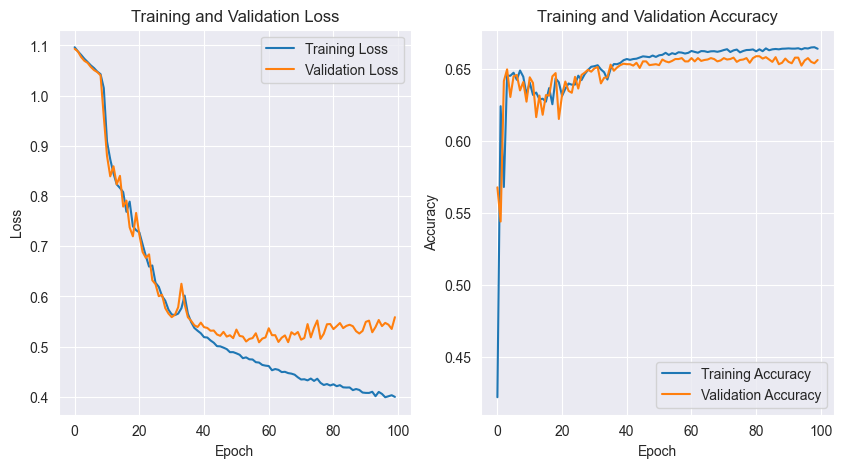

In [28]:
def plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list):
    plt.figure(figsize=(10, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list)

In [29]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [30]:
INDEX = 0

out = model.predict(X_test[:2500][INDEX])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])

Predicted class: calculator
True class: cell phone
